## Exploring venues in Indore, India

### Table of Contents

 - Introduction  
 - Data Collection from APIs  
 - Data Cleaning  
 - Methodolgy  
 - Analysis  
 - Results and Discussion  
 - Conclusion  

### Introduction

The aim of the project is to identify venues in Indore, India based on their rating and average prices. In this notebook, we will identify various venues in the city of __Indore, India__, using __Foursquare API__ and __Zomato API__, to help visitors select the restaurants that suit them the best.  
Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.  
Here, we'll __identify places that are fit for various individuals__ based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.  

### Data Collection from APIs

To begin with, we will take a look at __Indore on the Map__ using the folium library.  
We will also fetch the data from __two different APIs__.  

 - __Foursquare API__: We will use the Foursquare API to fetch venues in Indore starting from the middle upto 44 Kilometers in each direction.  
 - __Zomato API__: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Indore

__Indore__ is composed of a number of sectors spread across a total area of 530 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We can use the geopy library to extract the latitude and longitude values of Pune but it seems off and thus, we'll directly supply the values in this case.

In [2]:
TARGET_LATITUDE = 22.7196
TARGET_LONGITUDE = 75.8577
TARGET = 'Indore'
print('The geograpical coordinates of {} are {}, {}.'.format(TARGET, TARGET_LATITUDE, TARGET_LONGITUDE))

The geograpical coordinates of Indore are 22.7196, 75.8577.


In [3]:
import folium

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 12.5)
folium.Marker([TARGET_LATITUDE, TARGET_LONGITUDE]).add_to(target_location_map)
target_location_map.save("TargetMap.html")
target_location_map

### Foursquare API

We begin by fetching a total of all venues in Indore upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [4]:
FOURSQUARE_CLIENT_ID = '0HH2B0MRFB2FALD3CL3SQAGF5KPCVO53DS5OEOKOP4MWUCJO'
FOURSQUARE_CLIENT_SECRET = 'D5KMPZK1RAFC0RSUS3VCUOIAIIA2KVCOWHIP1RJX3D1L0UQS'
RADIUS = 6000 # 6 Km
NO_OF_VENUES = 100
VERSION = '20200426' # Current date

We define the get_category_type method to get the correct category for each venue.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

 - Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
 - We will set the radius as 4 Kilometers.
 - The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        TARGET_LATITUDE, 
                                                                        TARGET_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)
    
    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 75 venues fetched within a total radius of 6.0 Km

Total 75 venues fetched


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

 - The query will be the name of the venue.
 - The start defines from what offset we want to start, so we'll keep it at 0.
 - The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
 - We will supply the latitude and longitude values.
 - We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

In [7]:
headers = {'user-key': 'df1145140716bb75945b27ee861a1c62'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There was an error...")
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [8]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

### Data Cleaning 

The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [9]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map.save("Venues by Foursquare.html")
target_location_map

From the map, we can infer that there are clusters of venues around Vijay Nagar, Palasia and Indore Junction. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [10]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map.save("Venues by Zomato.html")
target_location_map

In [11]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [12]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [13]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Shreemaya Hotel Indore,Hotel,22.7151,75.8746,Cheers Cafe,22.7152,75.8749,200.0,1.0,2.9,"G-1/1, Sapna Chamber, 12/1, RNT Marg, Indore",0.0001,0.0003
1,56 Dukan,Plaza,22.7241,75.8848,Chaap Adda,22.7241,75.8848,300.0,1.0,3.5,"Shop 56, Lower Ground 02, One Centre, New Pala...",0.0000,0.0000
2,Lotus Hut Cafe,Coffee Shop,22.7209,75.8759,Lotus Hut,22.7209,75.8758,350.0,2.0,3.9,"17, MG Road, South Tukoganj, Indore",0.0000,-0.0001
3,Mr Beans,Cafeteria,22.7233,75.8969,Mr. Beans,22.7232,75.8967,800.0,3.0,4.3,"100, Saket, Old Palasia, Indore",-0.0001,-0.0002
4,Bablu Sandwich,Sandwich Place,22.7036,75.8554,Prem Prakash,22.7035,75.8555,350.0,2.0,3.8,"Prem Nagar Square, Manik Bagh Overbridge Corne...",-0.0001,0.0001
5,"Ccd,apollo Square",Café,22.7264,75.8810,Cafe Coffee Day,22.7262,75.8810,500.0,2.0,3.7,"Apollo Square, Race Course Road, Near Janjeerw...",-0.0002,0.0000
6,Sky Sheesha Lounge,Hookah Bar,22.7441,75.8946,Sky Blue Sports Bar,22.7440,75.8944,1800.0,4.0,3.5,"3rd Floor, C21 Mall, AB Road, Vijay Nagar, Indore",-0.0001,-0.0002
7,Celebrations Shreemaya,Restaurant,22.7153,75.8751,Hotel Shreemaya,22.7152,75.8750,1100.0,3.0,4.4,"12, South Tukoganj, RNT Marg Indore",-0.0001,-0.0001
8,Top n town,Ice Cream Shop,22.7257,75.8774,Top 'N' Town,22.7257,75.8775,200.0,1.0,4.2,"14/8, Race Course Road, YN Road, Indore",0.0000,0.0001
9,Cafe Palette,Café,22.7214,75.8875,Coksa Cafe,22.7214,75.8872,250.0,1.0,0,"24/2, Manorama Ganj, Near Sanghi Motors, Geeta...",0.0000,-0.0003


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

Category 1: There are venues that have specific restaurants/cafes inside them as provided by Zomato API .

Category 2: Two locations are so close by that they have practically same latitude and longitude values .

Category 3: Some have been replaced with new restaurants.

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [14]:
selected_venues = selected_venues.drop([0]).reset_index(drop = True)

In [15]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [16]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.5,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0
1,Coffee Shop,Lotus Hut,22.7209,75.8758,2.0,3.9,"17, MG Road, South Tukoganj, Indore",175.0
2,Cafeteria,Mr. Beans,22.7232,75.8967,3.0,4.3,"100, Saket, Old Palasia, Indore",400.0
3,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.8,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0
4,Café,Cafe Coffee Day,22.7262,75.8810,2.0,3.7,"Apollo Square, Race Course Road, Near Janjeerw...",250.0


I'll drop the venues which have 0.0 rating as it means it's not been rated yet.

In [17]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 29


### Methodology 

This project aims at identifying the venues in __Indore__ based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the __data from two APIs (Foursquare and Zomato)__. We extract venue information from the center of Indore, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then __explored the data__ retrieved from the two APIs on the map and identified the top category types. The __data from the two sources is carefully combined__ based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll __analyse the data__ that we created based on the ratings and price of each venue. We'll __identify places where many venues are located__ so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore __areas that are high rated and those that are low rated__ while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

### Analysis

The complete dataset is now in its final form.

We will __inspect these venues based on their rating__. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also __analyse the venues based on their price per person as well as the price range__.

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 20 artists>

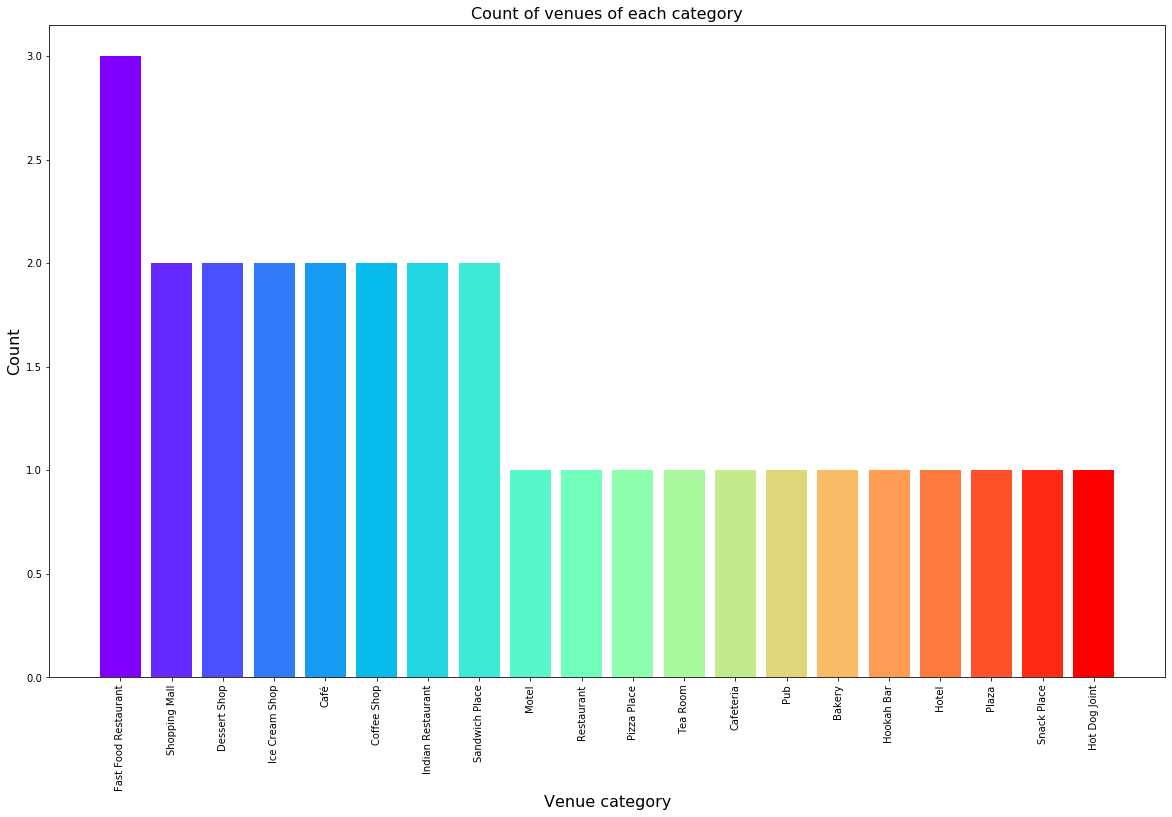

In [18]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are __Hotel__ and __Indian Restaurant__. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

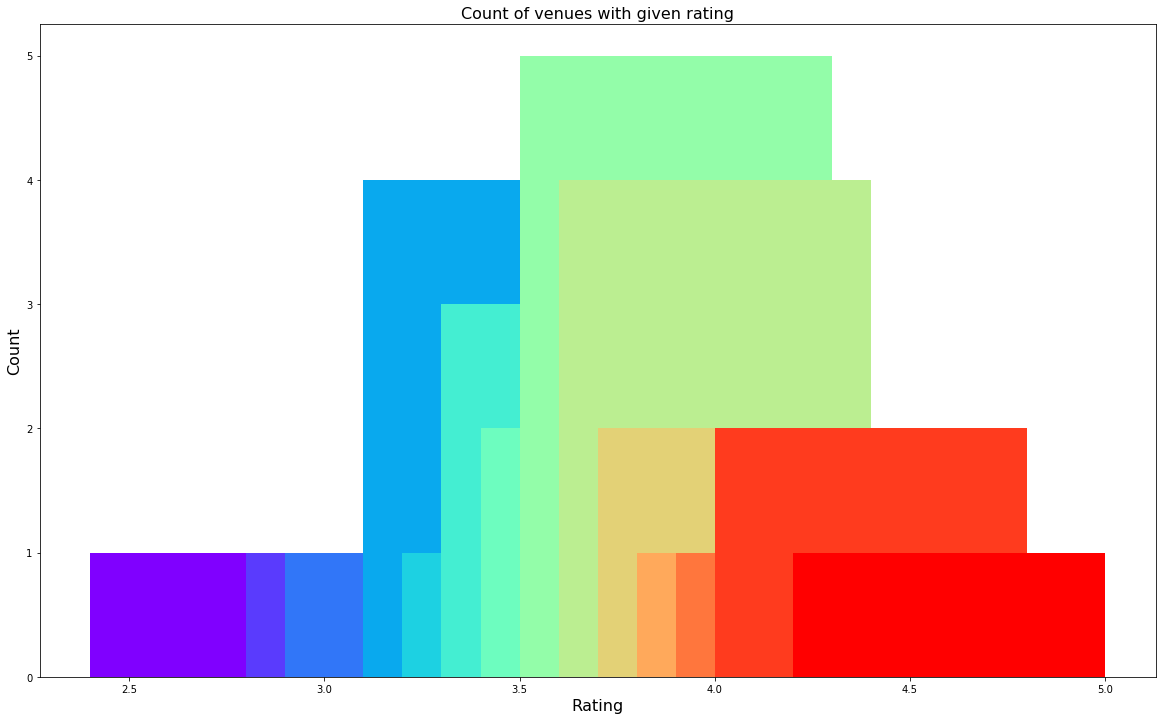

In [19]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

 - 1 to 2
 - 2 to 3
 - 3 to 4
 - 4 to 5

In [34]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [36]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(target_location_map)  

target_location_map.save("Venues Ratings.html")
target_location_map

The map has the location of all the venues. It appears that many venues are located near about Vijay Nagar, Palasia and  High Street with rating above 3. If someone wants to explore new venues, they should definitely check out these areas.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

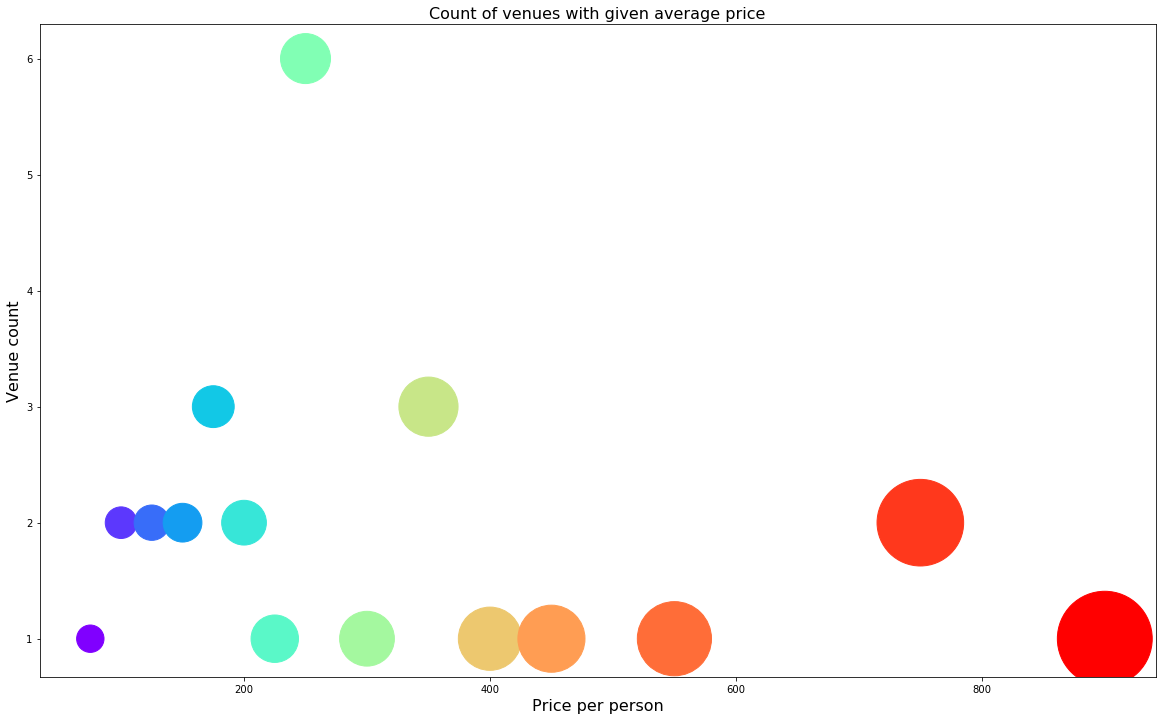

In [37]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 400 and Rs 700.

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [38]:
color_map = {1: 'green', 2: 'darkgreen', 3: 'orange', 4: 'red'}

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[_bin]),
        popup = label).add_to(target_location_map) 

target_location_map.save("Venues Prices.html")
target_location_map

NameError: name '_bin' is not defined

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [39]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.5,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0,Good
1,0,Coffee Shop,Lotus Hut,22.7209,75.8758,2.0,3.9,"17, MG Road, South Tukoganj, Indore",175.0,Good
2,0,Cafeteria,Mr. Beans,22.7232,75.8967,3.0,4.3,"100, Saket, Old Palasia, Indore",400.0,Very good
3,0,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.8,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0,Good
4,0,Café,Cafe Coffee Day,22.7262,75.8810,2.0,3.7,"Apollo Square, Race Course Road, Near Janjeerw...",250.0,Good


In [40]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(target_location_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(target_location_map)

target_location_map.save("Venues Clusters.html")
target_location_map

From the map, we see the two clusters:

The first cluster is spread across the whole city and includes the majority venues.
The second cluster is very sparsely spread and has very limited venues.

In [41]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.5,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0,Good
1,0,Coffee Shop,Lotus Hut,22.7209,75.8758,2.0,3.9,"17, MG Road, South Tukoganj, Indore",175.0,Good
2,0,Cafeteria,Mr. Beans,22.7232,75.8967,3.0,4.3,"100, Saket, Old Palasia, Indore",400.0,Very good
3,0,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.8,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0,Good
4,0,Café,Cafe Coffee Day,22.7262,75.8810,2.0,3.7,"Apollo Square, Race Course Road, Near Janjeerw...",250.0,Good
5,0,Ice Cream Shop,Top 'N' Town,22.7257,75.8775,1.0,4.2,"14/8, Race Course Road, YN Road, Indore",100.0,Very good
6,0,Sandwich Place,Subway,22.7447,75.8943,2.0,3.9,"Ground Floor, Malhar Mega Mall, Vijay Nagar, I...",250.0,Good
7,0,Indian Restaurant,The Roof,22.7240,75.8856,3.0,3.5,"Hotel Kanchan Tilak, 582/2, MG Road, New Palas...",450.0,Good
8,0,Ice Cream Shop,Sheetal Gazak & Kulfi,22.7209,75.8739,1.0,4.1,"Near Rajani Bhawan, YN Road, Indore",125.0,Very good
9,0,Coffee Shop,Cafe Coffee Day,22.6977,75.8772,2.0,3.7,"BCM City Building, AB Road, Near Navalakha Squ...",250.0,Good


In [42]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.80 and rating spread around 3.84


In [43]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hookah Bar,Sky Blue Sports Bar,22.7440,75.8944,4.0,3.5,"3rd Floor, C21 Mall, AB Road, Vijay Nagar, Indore",900.0,Good
1,1,Restaurant,Hotel Shreemaya,22.7152,75.8750,3.0,4.4,"12, South Tukoganj, RNT Marg Indore",550.0,Very good
2,1,Motel,Level 3,22.7526,75.8965,4.0,3.5,"Second Floor, Mangal City Mall, AB Road, Vijay...",750.0,Good
3,1,Hotel,Kava - Fairfield by Marriott,22.7481,75.9039,4.0,3.9,"Plot 18/C, Scheme 94, Ring Road, Vijay Nagar, ...",750.0,Good


In [44]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 3.75 and rating spread around 3.83


### Results and Discussion 

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Indore, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 90 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 35.

We identified that from the total set of venues, majority of them were Cafes and Indian Restaurants. A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Indore.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around Vijay Nagar, Palasia and Rajbada. These clusters also have very high ratings (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of Rs 400 to Rs 700 for one person. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near Vijay Nagar and Rajbada are relatively priced lower than venues in Palasia.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.03.

 - If you're looking for cheap places with relatively high rating, you should check Vijay Nagar.
 - If you're looking for the best places, with the highest rating but might also carry a high price tag, you should visit Palasia and Rajbada.
A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).



### Conclusion 

The purpose of this project was to explore the places that a person visiting Indore could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Vijay Nagar, Rajbada & Palasia. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.